In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import copy

%load_ext autoreload
%autoreload 2
from base import utils, datahandler, prediction_models, evaluation

2023-12-28 20:56:06.251194: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-28 20:56:06.365548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 20:56:06.365589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 20:56:06.384351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 20:56:06.426853: I tensorflow/core/platform/cpu_feature_guar

In [30]:
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)
label_df = pd.read_csv(labels_dir)

   ObjectID  TimeIndex Direction Node Type
0        21          0        EW   SS   HK
1        21          0        NS   SS   HK
2        21       2171        ES   ES   ES
3       198          0        EW   SS   HK
4       198          0        NS   SS   HK


In [3]:
concatenated_dataframes = pd.concat(split_dataframes.values())
# re-arrange columns
cols = concatenated_dataframes.columns.to_list()
cols.remove('ObjectID')
cols.remove('TimeIndex')
cols_ordered = ['ObjectID', 'TimeIndex'] + cols
df = concatenated_dataframes[cols_ordered]

In [4]:
df.reset_index(inplace=True, drop=True)
inputs = df.columns.to_list()
print(inputs)
newvals = np.sin(np.deg2rad(df['True Anomaly (deg)']))
print(newvals.shape)
df.loc['True Anomaly (sin)'] = newvals
inputs = concatenated_dataframes.columns.to_list()
print(inputs)
inputs.remove('ObjectID')
inputs.remove('TimeIndex')
inputs.remove('EW')
inputs.remove('EW_Node')
inputs.remove('EW_Type')
inputs.remove('NS')
inputs.remove('NS_Node')
inputs.remove('NS_Type')
print(len(inputs))

['ObjectID', 'TimeIndex', 'Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)', 'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)', 'EW', 'EW_Node', 'EW_Type', 'NS', 'NS_Node', 'NS_Type']
(544860,)
['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)', 'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)', 'ObjectID', 'TimeIndex', 'EW', 'EW_Node', 'EW_Type', 'NS', 'NS_Node', 'NS_Type']
15


/tmp/ipykernel_6292/2176343157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc['True Anomaly (sin)'] = newvals


In [5]:
scaled_df = df.copy()
scaled_df[inputs] = StandardScaler().fit_transform(df[inputs].values)


In [16]:
def plot_hists(df, ObjectID):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,12))
    if ObjectID is not None:
        df=df.loc[df['ObjectID'] == 1]
    plt.tight_layout()
    for row in range(4):
        for column in range(4):
            if row==3 and column==3:
                continue
            feature = inputs[row*4+column]
            axes[row,column].hist(df[feature], bins=30)
            axes[row,column].title.set_text(feature)
    fig.show()

def plot_vals(df, objects=[], time_index_start=0, time_index_end=None):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,12))
    plt.tight_layout()
    for row in range(4):
        for column in range(4):
            if row==3 and column==3:
                continue
            feature = inputs[row*4+column]
            if objects:
                for object in objects:
                    obj_df = df.loc[df['ObjectID'] == object]
                    if time_index_end is not None:
                        obj_df=obj_df[time_index_start:time_index_end]
                    axes[row,column].plot(obj_df['TimeIndex'], obj_df[feature], label=str(object))
                axes[row,column].legend()
            else:
                axes[row,column].plot(df['TimeIndex'], df[feature])
            axes[row,column].title.set_text(feature)
    fig.show()

/tmp/ipykernel_6292/2246985923.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_6292/2246985923.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


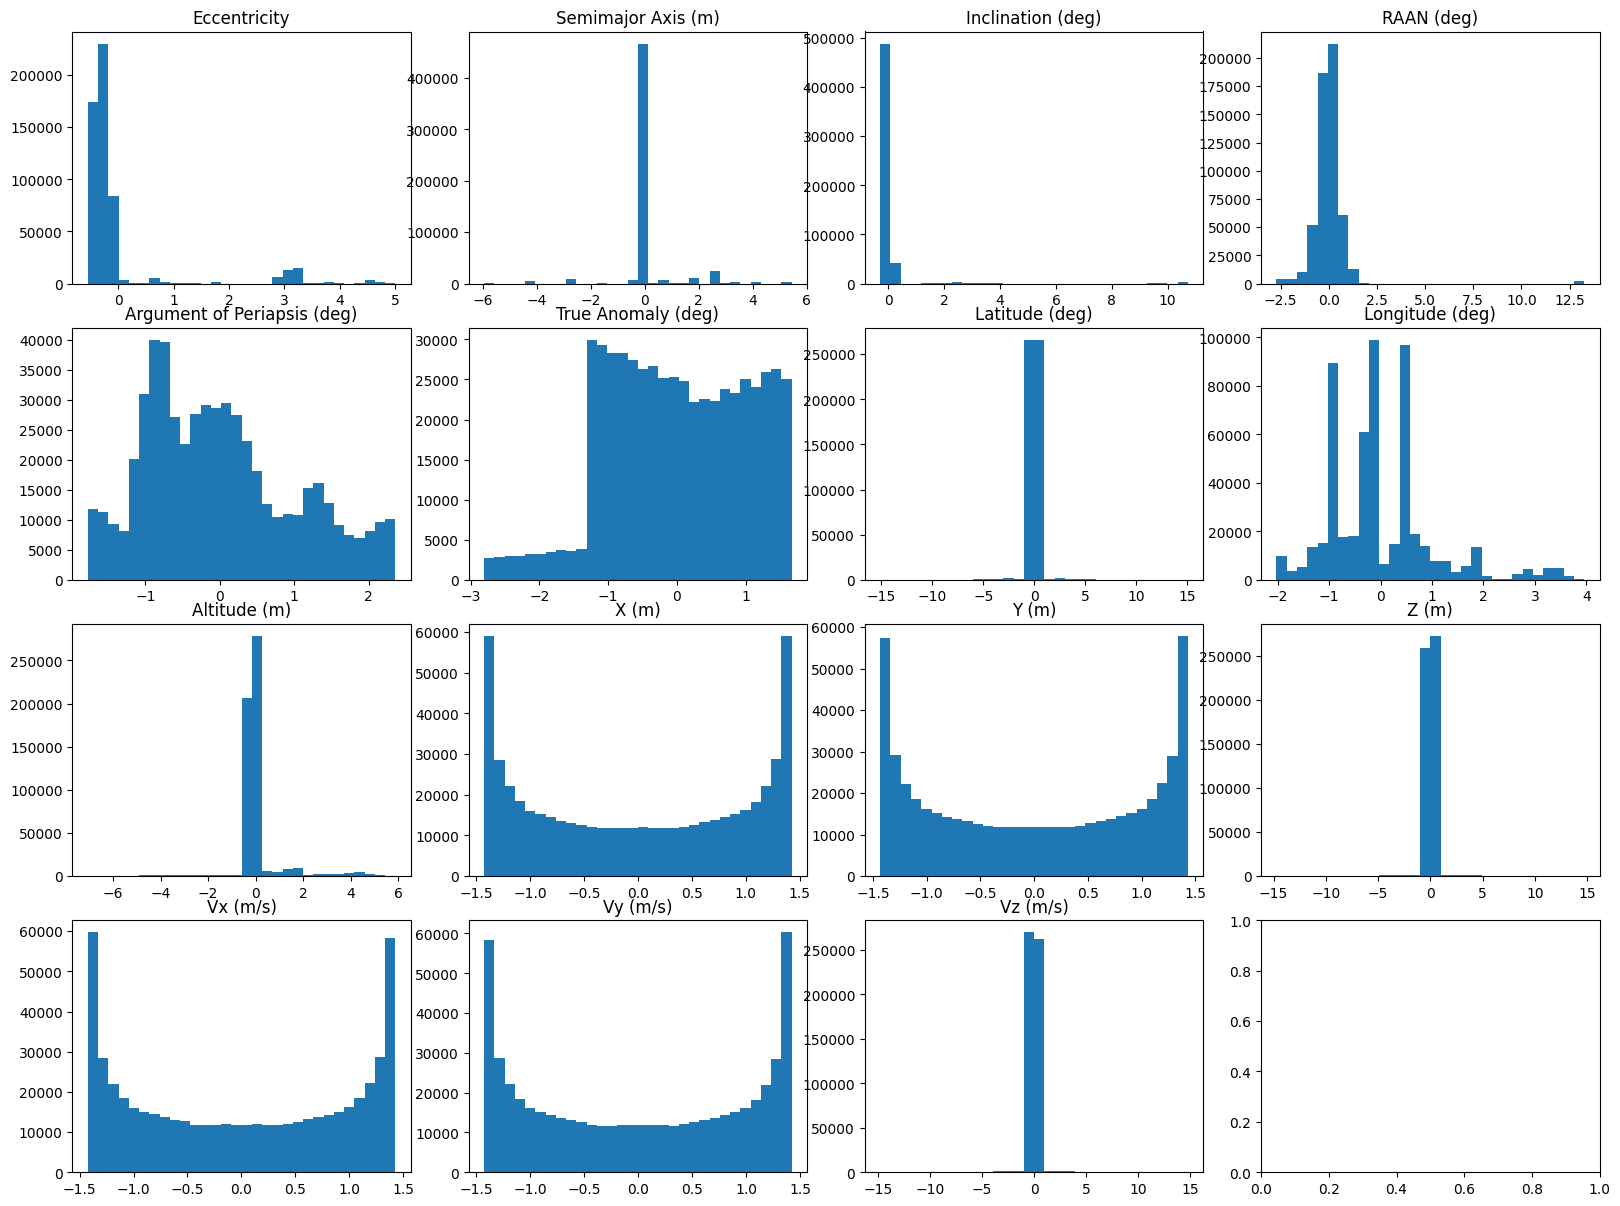

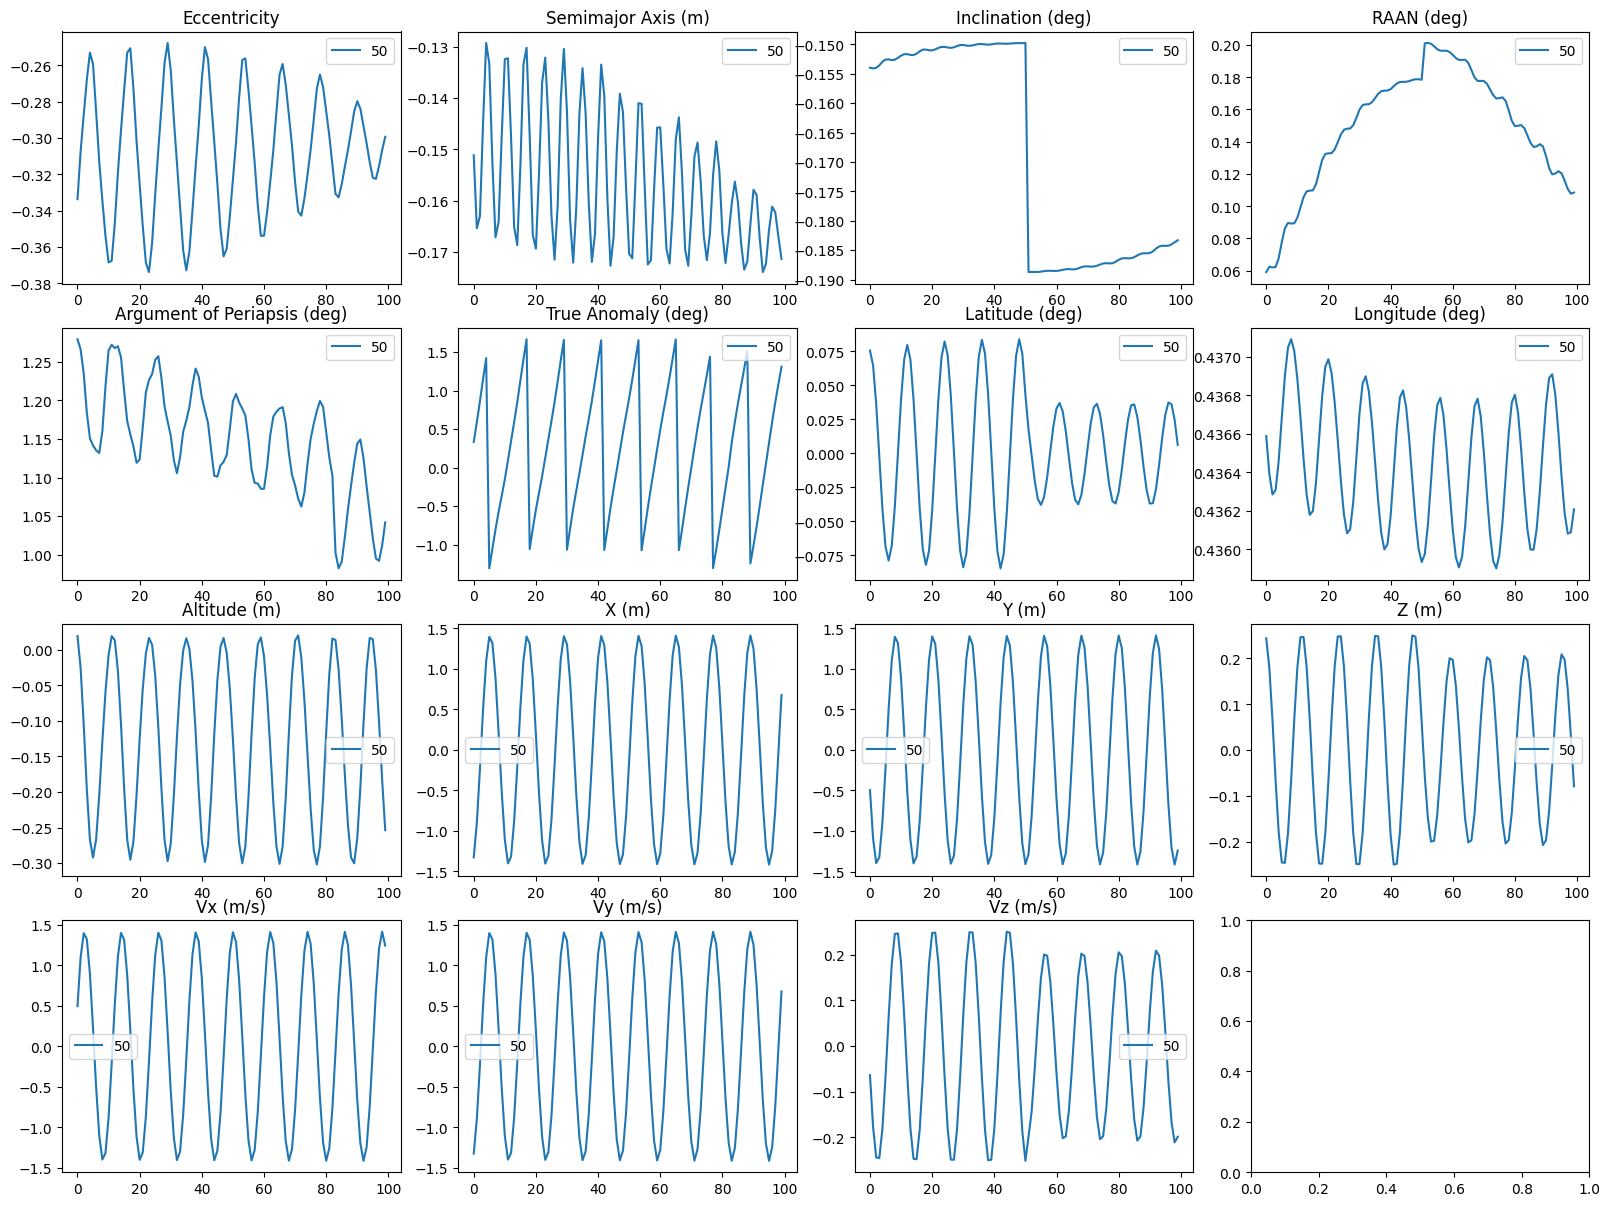

In [17]:
plot_hists(scaled_df, None)
plot_vals(scaled_df, [50], time_index_start=0, time_index_end=100)

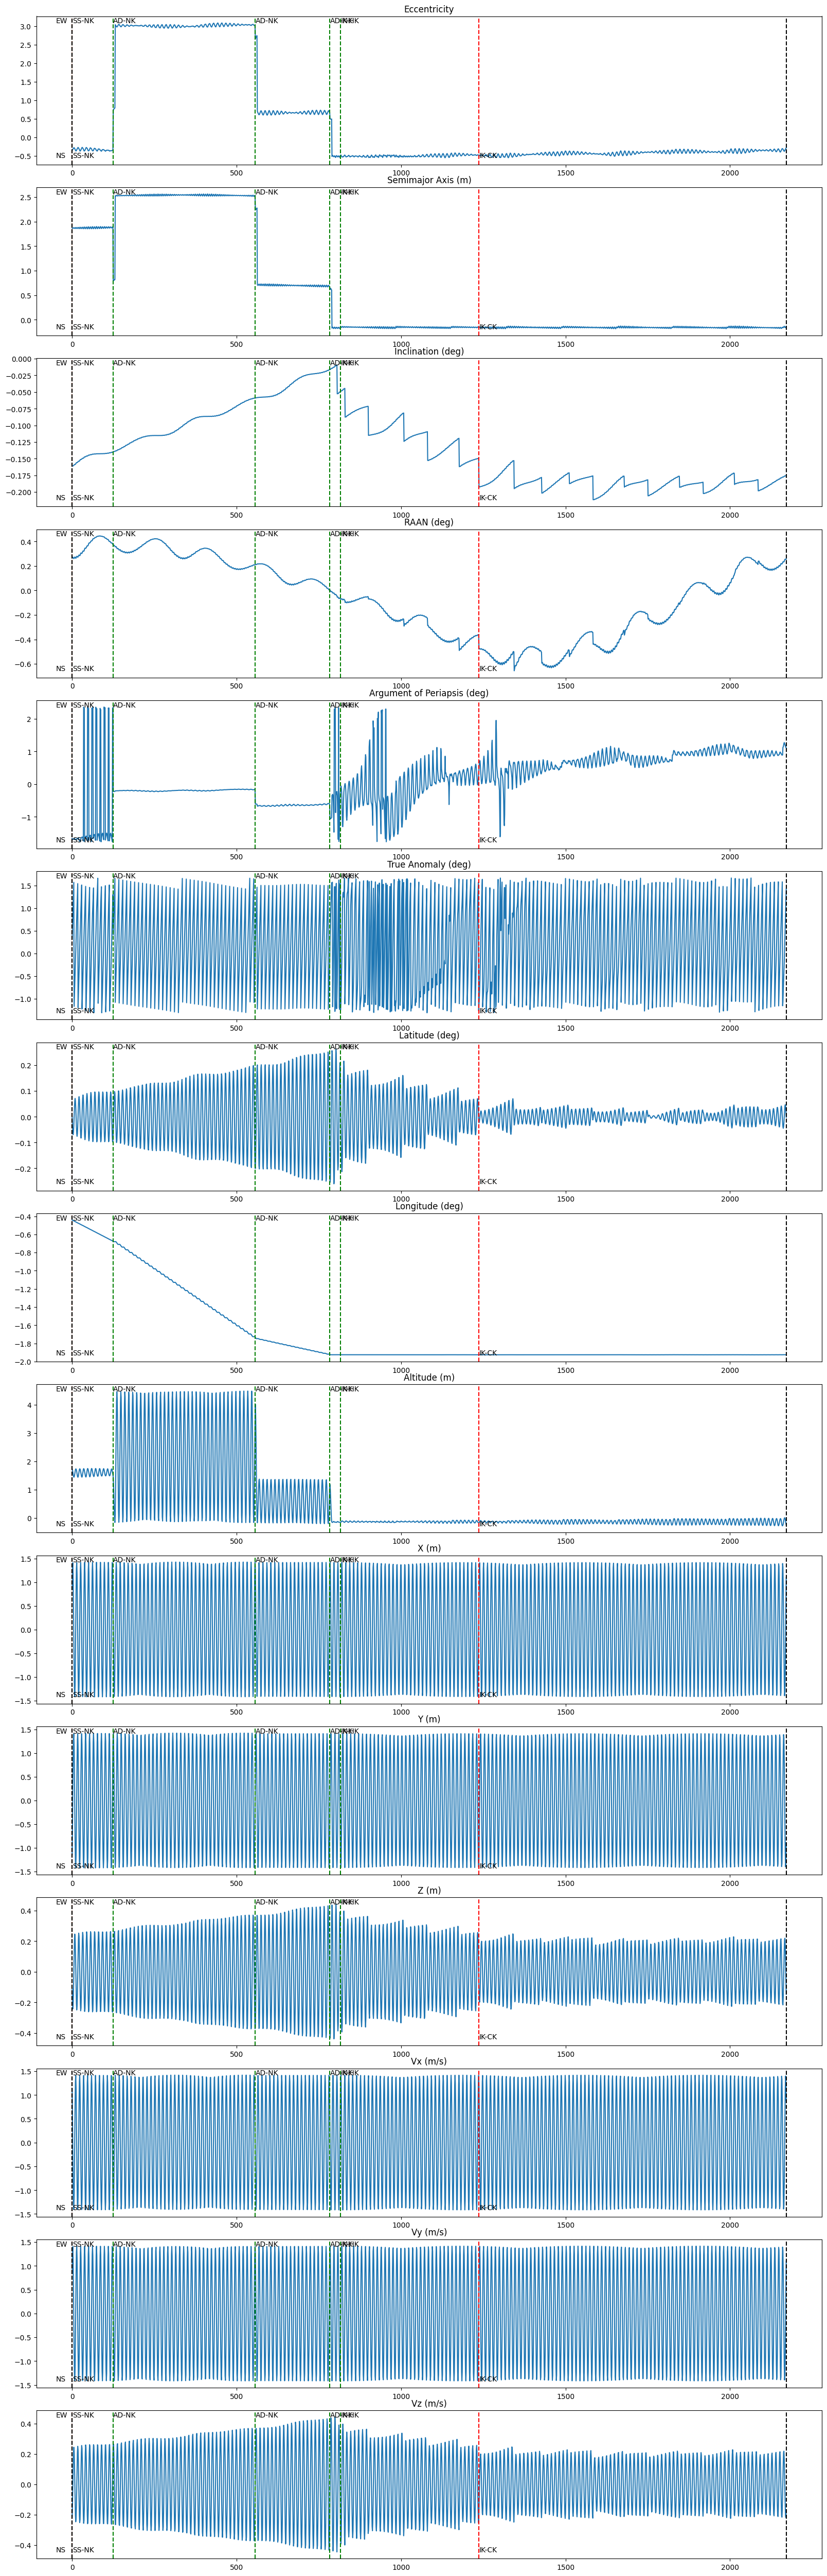

In [68]:
def plot_object(df, labels_df, object_id):
    obj_df = df.loc[df['ObjectID'] == object_id]
    labels = labels_df.loc[labels_df['ObjectID'] == object_id]
    fig, axes = plt.subplots(nrows=15, ncols=1, figsize=(16,50))
    plt.tight_layout()
    for ft_idx, input_ft in enumerate(inputs):
        axes[ft_idx].plot(obj_df['TimeIndex'], obj_df[input_ft], label=input_ft)
        axes[ft_idx].text(-50.0,np.min(obj_df[input_ft]),'NS',rotation=0.0)
        axes[ft_idx].text(-50.0,np.max(obj_df[input_ft]),'EW',rotation=0.0)
        for index, row in labels.iterrows():
            if row['Direction'] == 'EW':
                axes[ft_idx].axvline(row['TimeIndex'],color='g', linestyle="--")
                label=row['Node'] + '-' + row['Type']
                axes[ft_idx].text(row['TimeIndex'] + 1.0,np.max(obj_df[input_ft]),label,rotation=0.0)
            elif row['Direction'] == 'NS':
                axes[ft_idx].axvline(row['TimeIndex'],color='r', linestyle="--")
                label=row['Node'] + '-' + row['Type']
                axes[ft_idx].text(row['TimeIndex'] + 1.0,np.min(obj_df[input_ft]),label,rotation=0.0)
        axes[ft_idx].axvline(0,color='black', linestyle="--")
        axes[ft_idx].axvline(np.max(obj_df['TimeIndex']),color='black', linestyle="--")
        axes[ft_idx].title.set_text(input_ft)
    plt.show()
plot_object(scaled_df, label_df, 121)

C:\Users\David\AppData\Local\Temp\ipykernel_9468\3015431758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Anomaly (sin)'] = np.sin(np.deg2rad(df['Mean Anomaly (deg)']))
C:\Users\David\AppData\Local\Temp\ipykernel_9468\3015431758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Anomaly (cos)'] = np.cos(np.deg2rad(df['Mean Anomaly (deg)']))
C:\Users\David\AppData\Local\Temp\ipykernel_9468\3015431758.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

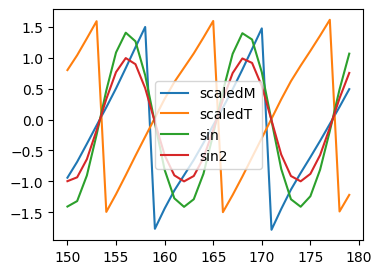

In [156]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
df['Mean Anomaly (sin)'] = np.sin(np.deg2rad(df['Mean Anomaly (deg)']))
df['Mean Anomaly (cos)'] = np.cos(np.deg2rad(df['Mean Anomaly (deg)']))
df[['Mean Anomaly (sin)', 'Mean Anomaly (cos)']] = StandardScaler().fit_transform(df[['Mean Anomaly (sin)', 'Mean Anomaly (cos)']].values)
obj_df = df.loc[df['ObjectID'] == 1][150:180]
#obj_df[inputs] = StandardScaler().fit_transform(obj_df[inputs].values)
obj_df_scaled = scaled_df.loc[df['ObjectID'] == 1][150:180]
ax.plot(obj_df['TimeIndex'], obj_df_scaled['Mean Anomaly (deg)'], label='scaledM')
ax.plot(obj_df['TimeIndex'], obj_df_scaled['True Anomaly (deg)'], label='scaledT')
ax.plot(obj_df['TimeIndex'], obj_df['Mean Anomaly (sin)'], label='sin')
ax.plot(obj_df['TimeIndex'], np.sin(np.deg2rad(obj_df['Mean Anomaly (deg)'])), label='sin2')
#ax.plot(obj_df['TimeIndex'], obj_df['Mean Anomaly (cos)'], label='cos')
#ax.plot(obj_df['TimeIndex'], np.arctan2(np.sin(np.deg2rad(obj_df['Mean Anomaly (deg)'])), np.cos(np.deg2rad(obj_df['Mean Anomaly (deg)']))), label='atan')
ax.legend()
fig.show()


In [11]:
# identify propulsion types per object
for key, df in split_dataframes.items():
    prop_types = set(list(df["EW_Type"].unique()) + list(df["NS_Type"].unique()))
    print(key, prop_types)
# seems like different object (122, 121) can have more than one propulsion type...
# 121 seems very strange in general
# there are some duplicate labels - problems during evaluation??? (121, 108 etc.)

77 {'CK'}
227 {'EK'}
57 {'CK', 'NK'}
190 {'NK', 'HK'}
162 {'CK', 'NK'}
215 {'NK', 'HK'}
157 {'CK', 'NK'}
135 {'CK', 'NK'}
47 {'CK', 'NK'}
130 {'CK', 'NK'}
206 {'NK', 'HK'}
99 {'CK'}
15 {'EK', 'CK'}
5 {'EK', 'CK'}
97 {'CK', 'NK'}
60 {'CK'}
141 {'CK', 'NK'}
116 {'NK', 'HK'}
138 {'CK', 'NK'}
181 {'NK', 'HK'}
143 {'CK', 'NK'}
161 {'CK', 'NK'}
62 {'CK'}
236 {'EK'}
79 {'CK'}
131 {'CK', 'NK'}
243 {'CK'}
76 {'CK'}
86 {'CK'}
72 {'CK'}
83 {'CK'}
159 {'CK', 'NK'}
240 {'CK'}
247 {'EK'}
217 {'NK', 'HK'}
209 {'NK', 'HK'}
177 {'CK', 'NK'}
114 {'NK', 'HK'}
23 {'CK'}
61 {'CK'}
94 {'CK'}
147 {'CK', 'NK'}
124 {'NK'}
52 {'CK'}
82 {'CK'}
90 {'CK', 'NK'}
232 {'NK', 'HK'}
101 {'CK', 'NK'}
102 {'CK', 'NK'}
183 {'NK', 'HK'}
7 {'CK'}
199 {'NK', 'HK'}
48 {'CK', 'NK'}
111 {'NK', 'HK'}
153 {'CK', 'NK'}
30 {'CK', 'NK'}
44 {'CK'}
24 {'CK', 'NK'}
129 {'CK', 'NK'}
137 {'CK', 'NK'}
237 {'EK', 'NK'}
13 {'NK', 'HK'}
117 {'NK', 'HK'}
231 {'CK'}
4 {'HK'}
21 {'HK'}
54 {'CK', 'NK'}
93 {'CK'}
19 {'CK', 'NK'}
151 {'CK', 'NK'}
